In [9]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from astropy.table import QTable, join
from scipy import stats

plt.style.use('paper.mplstyle')

import sys 
sys.path.append('../../../../misc/data_cube_analysis')  
from bindata import *
from histograms import *

In [10]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wprops.fits' %root_dir)
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,flag_touch_hst,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,t_N2_MUSE,t_S3_MUSE,t_N2_err_MUSE,t_S3_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,ne,rec_coeff,Q,radius_strom_pc,ne_strom_circ,ne_strom_mom,ne_strom_circ_muse
,,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,,,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),e

In [11]:
# Mask bad data...
mask_flags = ~((table['flag_edge_hst']==1)|(table['flag_edge_MUSE']==1)|(table['flag_star_MUSE']==1))
table = table[mask_flags]

# Mask HII regions...
mask_hiiregion = table['HII_class_v3_MUSE'] == True
table = table[mask_hiiregion]
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,flag_touch_hst,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,t_N2_MUSE,t_S3_MUSE,t_N2_err_MUSE,t_S3_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,ne,rec_coeff,Q,radius_strom_pc,ne_strom_circ,ne_strom_mom,ne_strom_circ_muse
,,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,,,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),e

In [12]:
mask_ne = ~np.isnan(table['ne'])
N_ne = len(table['ne'][mask_ne])
print('Number of ne measurements: %i' %N_ne)

Number of ne measurements: 2504


Text(0, 0.5, '$n_e$ (MUSE B24) [cm$^{-3}$]')

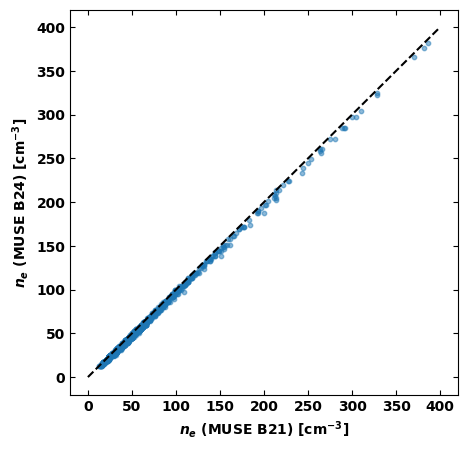

In [13]:
# This is just for checking - careful as some of the regions are not in the B21 catalogue... 
# As they're not resolved in the HST data, they're not included in the B21 catalogue... 

table_b21 = QTable.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
for key in table_b21.keys():
    if key == 'region_ID' or key == 'gal_name':
        continue
    table_b21.rename_column(key, key+'_MUSE_B21')

table_all = join(table, table_b21, keys=['region_ID', 'gal_name'])

table_all.sort(['gal_name', 'region_ID'])
# table_all

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(table_all['ne_MUSE_B21'].value, table_all['ne'].value, s=10, c='C0', alpha=0.5)
ax.plot([0, 400], [0, 400], 'k--')
ax.set_xlabel(r'$n_e$ (MUSE B21) [cm$^{-3}$]') # Barnes et al 2021
ax.set_ylabel(r'$n_e$ (MUSE B24) [cm$^{-3}$]') # This work

In [14]:
# mask = table['ne']
mask_nan = ~np.isnan(table['ne'])

radius_str = table['radius_strom_pc'][mask_nan]
radius_mom = table['mean_sigma_pc'][mask_nan]
radius_cir = table['radius_circ_pc'][mask_nan]
radius_cir_muse = table['region_circ_rad_pc_MUSE'][mask_nan]

ne = table['ne'][mask_nan]
ne_strom_circ = table['ne_strom_circ'][mask_nan]
ne_strom_mom = table['ne_strom_mom'][mask_nan]
ne_strom_circ_muse = table['ne_strom_circ_muse'][mask_nan]

print('Total number of regions: %i' %len(radius_cir_muse))

Total number of regions: 2504


/Users/abarnes/GitHub/phangs/analysis_phangs_hst/hstha_catalogue_v0p4/run_analysis/../../../../misc/data_cube_analysis/bindata.py:128: RuntimeWarning: divide by zero encountered in scalar divide
  significant[i] = y[i] / sigma[i]
/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/abarnes/GitHub/phangs/analysis_phangs_hst/hstha_catalogue_v0p4/run_analysis/../../../../misc/data_cube_analysis/bindata.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sigma_err_mean = sigma_err_var / np.sqrt(n / oversample)


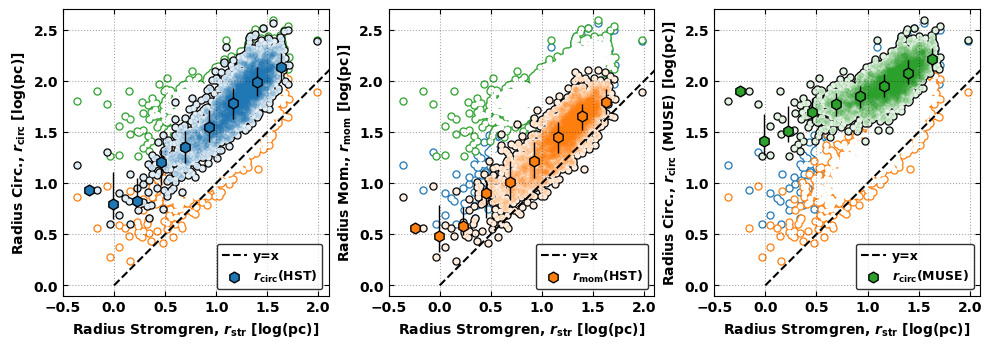

In [15]:
data_x = np.log10(np.array(radius_str.value))
data_y1 = np.log10(np.array(radius_cir.value))
data_y2 = np.log10(np.array(radius_mom.value))
data_y3 = np.log10(np.array(radius_cir_muse.value))

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(131, aspect='equal')
ax2 = fig.add_subplot(132, aspect='equal')
ax3 = fig.add_subplot(133, aspect='equal')

# Plot background data
ax2.scatter(data_x, data_y1, s=25, c='C0', rasterized=True)
ax2.scatter(data_x, data_y1, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y1, s=25, c='C0', rasterized=True)
ax3.scatter(data_x, data_y1, s=10, c='white', rasterized=True)

ax1.scatter(data_x, data_y2, s=25, c='C1', rasterized=True)
ax1.scatter(data_x, data_y2, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y2, s=25, c='C1', rasterized=True)
ax3.scatter(data_x, data_y2, s=10, c='white', rasterized=True)

ax1.scatter(data_x, data_y3, s=25, c='C2', rasterized=True)
ax1.scatter(data_x, data_y3, s=10, c='white', rasterized=True)
ax2.scatter(data_x, data_y3, s=25, c='C2', rasterized=True)
ax2.scatter(data_x, data_y3, s=10, c='white', rasterized=True)

# Plot main data
ax1.scatter(data_x, data_y1, s=25, c='black', rasterized=True)
ax1.scatter(data_x, data_y1, s=10, c='white', rasterized=True)
ax1.scatter(data_x, data_y1, s=10, c='C0', alpha=0.1, rasterized=True)

ax2.scatter(data_x, data_y2, s=25, c='black', rasterized=True)
ax2.scatter(data_x, data_y2, s=10, c='white', rasterized=True)
ax2.scatter(data_x, data_y2, s=10, c='C1', alpha=0.1, rasterized=True)

ax3.scatter(data_x, data_y3, s=25, c='black', rasterized=True)
ax3.scatter(data_x, data_y3, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y3, s=10, c='C2', alpha=0.1, rasterized=True)

ax1.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')
ax2.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')
ax3.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')

x, y, stats, bins = get_bins_1d(data_x, data_y1)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h', label='$r_\mathrm{circ}$(HST)')

x, y, stats, bins = get_bins_1d(data_x, data_y2)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=60, ec='black', fc='C1', zorder=10, marker='h', label='$r_\mathrm{mom}$(HST)')

x, y, stats, bins = get_bins_1d(data_x, data_y3)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=60, ec='black', fc='C2', zorder=10, marker='h', label='$r_\mathrm{circ}$(MUSE)')

for ax in [ax1, ax2, ax3]:

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Radius Stromgren, $r_\mathrm{str}$ [log(pc)]')

    ax.set_xlim(-0.5, 2.1)
    ax.set_ylim(-0.1, 2.7)

    ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)

ax1.set_ylabel('Radius Circ., $r_\mathrm{circ}$ [log(pc)]')
ax2.set_ylabel('Radius Mom., $r_\mathrm{mom}$ [log(pc)]')
ax3.set_ylabel('Radius Circ., $r_\mathrm{circ}$ (MUSE) [log(pc)]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radstromgrencomp.pdf', dpi=200, bbox_inches='tight')

/Users/abarnes/GitHub/phangs/analysis_phangs_hst/hstha_catalogue_v0p4/run_analysis/../../../../misc/data_cube_analysis/bindata.py:128: RuntimeWarning: divide by zero encountered in scalar divide
  significant[i] = y[i] / sigma[i]


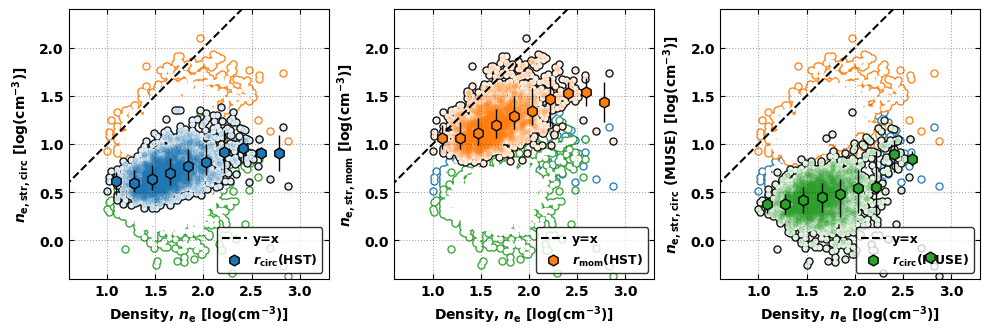

In [16]:
data_x = np.log10(np.array(ne.value))
data_y1 = np.log10(np.array(ne_strom_circ.value))
data_y2 = np.log10(np.array(ne_strom_mom.value))
data_y3 = np.log10(np.array(ne_strom_circ_muse.value))

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(131, aspect='equal')
ax2 = fig.add_subplot(132, aspect='equal')
ax3 = fig.add_subplot(133, aspect='equal')

# Plot background data
ax2.scatter(data_x, data_y1, s=25, c='C0', rasterized=True)
ax2.scatter(data_x, data_y1, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y1, s=25, c='C0', rasterized=True)
ax3.scatter(data_x, data_y1, s=10, c='white', rasterized=True)

ax1.scatter(data_x, data_y2, s=25, c='C1', rasterized=True)
ax1.scatter(data_x, data_y2, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y2, s=25, c='C1', rasterized=True)
ax3.scatter(data_x, data_y2, s=10, c='white', rasterized=True)

ax1.scatter(data_x, data_y3, s=25, c='C2', rasterized=True)
ax1.scatter(data_x, data_y3, s=10, c='white', rasterized=True)
ax2.scatter(data_x, data_y3, s=25, c='C2', rasterized=True)
ax2.scatter(data_x, data_y3, s=10, c='white', rasterized=True)

# Plot main data
ax1.scatter(data_x, data_y1, s=25, c='black', rasterized=True)
ax1.scatter(data_x, data_y1, s=10, c='white', rasterized=True)
ax1.scatter(data_x, data_y1, s=10, c='C0', alpha=0.1, rasterized=True)

ax2.scatter(data_x, data_y2, s=25, c='black', rasterized=True)
ax2.scatter(data_x, data_y2, s=10, c='white', rasterized=True)
ax2.scatter(data_x, data_y2, s=10, c='C1', alpha=0.1, rasterized=True)

ax3.scatter(data_x, data_y3, s=25, c='black', rasterized=True)
ax3.scatter(data_x, data_y3, s=10, c='white', rasterized=True)
ax3.scatter(data_x, data_y3, s=10, c='C2', alpha=0.1, rasterized=True)

ax1.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')
ax2.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')
ax3.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')

x, y, stats, bins = get_bins_1d(data_x, data_y1)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h', label='$r_\mathrm{circ}$(HST)')

x, y, stats, bins = get_bins_1d(data_x, data_y2)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=60, ec='black', fc='C1', zorder=10, marker='h', label='$r_\mathrm{mom}$(HST)')

x, y, stats, bins = get_bins_1d(data_x, data_y3)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=60, ec='black', fc='C2', zorder=10, marker='h', label='$r_\mathrm{circ}$(MUSE)')

for ax in [ax1, ax2, ax3]:

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Density, $n_\mathrm{e}$ [log(cm$^{-3}$)]')

    ax.set_xlim(0.6, 3.3)
    ax.set_ylim(-0.4, 2.4)

    ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)

ax1.set_ylabel('$n_\mathrm{e,str,circ}$ [log(cm$^{-3}$)]')
ax2.set_ylabel('$n_\mathrm{e,str,mom}$ [log(cm$^{-3}$)]')
ax3.set_ylabel('$n_\mathrm{e,str,circ}$ (MUSE) [log(cm$^{-3}$)]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_nestromgrencomp.pdf', dpi=200, bbox_inches='tight')